In [ ]:
import os
import json
import requests
import re
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from tabulate import tabulate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tải file questions, annotations từ VQA

In [ ]:
# Đường dẫn thư mục chính
DATASET_PATH = "/content/drive/MyDrive/midterm_deep_learning/dataset"
# Tạo các thư mục cần thiết
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations")
QUESTIONS_PATH = os.path.join(DATASET_PATH, "questions")
IMAGES_PATH = os.path.join(DATASET_PATH, "images")

os.makedirs(ANNOTATIONS_PATH, exist_ok=True)
os.makedirs(QUESTIONS_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

# URLs của annotation và question files
files_to_download = {
    "annotations": [
        "https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip",
    ],
    "questions": [
        "https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip",
    ]
}

# Hàm tải file nếu chưa tồn tại
def download_and_extract(url, save_dir):
    filename = url.split("/")[-1]
    zip_path = os.path.join(save_dir, filename)

    # Kiểm tra xem file đã được giải nén chưa
    extracted_file = filename.replace(".zip", ".json")
    extracted_path = os.path.join(save_dir, extracted_file)

    if os.path.exists(extracted_path):
        print(f"✅ {extracted_file} đã tồn tại, bỏ qua tải xuống.")
    else:
        print(f"⬇️ Đang tải: {filename} ...")
        !wget -O {zip_path} {url}
        !unzip -o {zip_path} -d {save_dir}
        os.remove(zip_path)  # Xóa file ZIP sau khi giải nén
        print(f"✅ {extracted_file} đã tải xong và giải nén!")

# Tải annotation files
for url in files_to_download["annotations"]:
    download_and_extract(url, ANNOTATIONS_PATH)

# Tải question files
for url in files_to_download["questions"]:
    download_and_extract(url, QUESTIONS_PATH)


⬇️ Đang tải: v2_Annotations_Train_mscoco.zip ...
--2025-03-16 04:37:54--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.73.40, 52.217.229.144, 52.217.129.88, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.73.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21708861 (21M) [application/zip]
Saving to: ‘/content/drive/MyDrive/midterm_deep_learning/dataset/annotations/v2_Annotations_Train_mscoco.zip’

/content/drive/MyDr 100%[===================>]  20.70M  30.9MB/s    in 0.7s    

2025-03-16 04:37:54 (30.9 MB/s) - ‘/content/drive/MyDrive/midterm_deep_learning/dataset/annotations/v2_Annotations_Train_mscoco.zip’ saved [21708861/21708861]

Archive:  /content/drive/MyDrive/midterm_deep_learning/dataset/annotations/v2_Annotations_Train_mscoco.zip
  inflating: /content/drive/MyDrive/midterm_deep_learning/dataset/annotations/v2_mscoco_train2014_annotations.json  
✅ v2

# Lọc id các ảnh là động vật từ dataset của COCO

In [ ]:
# Tải file instances_train2014.json từ COCO để lấy id các categories có trong dataset
coco_annotation_url = "http://images.cocodataset.org/annotations/annotations_trainval2014.zip"

download_and_extract(coco_annotation_url, DATASET_PATH)

# Danh sách các file cần xóa
delete_file = ['captions_train2014.json', 'captions_val2014.json',
               'instances_val2014.json', 'person_keypoints_train2014.json',
               'person_keypoints_val2014.json']

# Lặp qua danh sách và xóa từng file
for file in delete_file:
    file_path = f"{ANNOTATIONS_PATH}/{file}"
    if os.path.exists(file_path):  # Kiểm tra nếu file tồn tại rồi mới xóa
        !rm {file_path}


⬇️ Đang tải: annotations_trainval2014.zip ...
--2025-03-16 04:38:02--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.44.132, 54.231.197.137, 52.216.32.49, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.44.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘/content/drive/MyDrive/midterm_deep_learning/dataset/annotations_trainval2014.zip’

/content/drive/MyDr 100%[===================>] 241.16M  30.2MB/s    in 7.3s    

2025-03-16 04:38:09 (32.9 MB/s) - ‘/content/drive/MyDrive/midterm_deep_learning/dataset/annotations_trainval2014.zip’ saved [252872794/252872794]

Archive:  /content/drive/MyDrive/midterm_deep_learning/dataset/annotations_trainval2014.zip
  inflating: /content/drive/MyDrive/midterm_deep_learning/dataset/annotations/instances_train2014.json  
  inflating: /content/drive/MyDrive/midterm

In [ ]:
# Đọc file instances_train2014.json
instances_path = f"{ANNOTATIONS_PATH}/instances_train2014.json"
with open(instances_path, "r") as f:
    instances_data = json.load(f)

# Lấy danh sách categories
categories = instances_data["categories"]

# In danh sách ID và tên category
print("📌 Danh sách categories trong COCO:")
for category in categories:
    print(f"ID: {category['id']}, Tên: {category['name']}")

📌 Danh sách categories trong COCO:
ID: 1, Tên: person
ID: 2, Tên: bicycle
ID: 3, Tên: car
ID: 4, Tên: motorcycle
ID: 5, Tên: airplane
ID: 6, Tên: bus
ID: 7, Tên: train
ID: 8, Tên: truck
ID: 9, Tên: boat
ID: 10, Tên: traffic light
ID: 11, Tên: fire hydrant
ID: 13, Tên: stop sign
ID: 14, Tên: parking meter
ID: 15, Tên: bench
ID: 16, Tên: bird
ID: 17, Tên: cat
ID: 18, Tên: dog
ID: 19, Tên: horse
ID: 20, Tên: sheep
ID: 21, Tên: cow
ID: 22, Tên: elephant
ID: 23, Tên: bear
ID: 24, Tên: zebra
ID: 25, Tên: giraffe
ID: 27, Tên: backpack
ID: 28, Tên: umbrella
ID: 31, Tên: handbag
ID: 32, Tên: tie
ID: 33, Tên: suitcase
ID: 34, Tên: frisbee
ID: 35, Tên: skis
ID: 36, Tên: snowboard
ID: 37, Tên: sports ball
ID: 38, Tên: kite
ID: 39, Tên: baseball bat
ID: 40, Tên: baseball glove
ID: 41, Tên: skateboard
ID: 42, Tên: surfboard
ID: 43, Tên: tennis racket
ID: 44, Tên: bottle
ID: 46, Tên: wine glass
ID: 47, Tên: cup
ID: 48, Tên: fork
ID: 49, Tên: knife
ID: 50, Tên: spoon
ID: 51, Tên: bowl
ID: 52, Tên: ban

In [ ]:
# Từ danh sách categories ở trên ta có thể thu được id các ảnh animal
animal_category_ids = [16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

In [ ]:
# Lọc các ảnh có ít nhất một đối tượng thuộc animal_category_ids
animal_image_ids = set()  # Dùng set để tránh trùng lặp
for annotation in instances_data["annotations"]:
    if annotation["category_id"] in animal_category_ids:
        animal_image_ids.add(annotation["image_id"])

# Chuyển set thành danh sách
animal_image_ids = list(animal_image_ids)
print(f"Lấy được ID của {len(animal_image_ids)} ảnh chứa động vật!")


Lấy được ID của 16740 ảnh chứa động vật!


# Tải các ảnh từ dataset của COCO khi có danh sách id các ảnh cần tải là animal_image_ids

In [ ]:
def download_image(image_id, save_dir='.'):
    ''' Tải ảnh từ COCO và lưu vào thư mục save_dir '''
    # Tạo thư mục nếu chưa có
    os.makedirs(save_dir, exist_ok=True)
    image_filename = f"{image_id}.jpg"
    image_path = os.path.join(save_dir, image_filename)

    # Nếu ảnh đã tồn tại -> Bỏ qua
    if os.path.exists(image_path):
        return image_path

    # Tạo URL tải ảnh từ COCO
    image_url = f"http://images.cocodataset.org/train2014/COCO_train2014_{image_id:012d}.jpg"

    try:
        response = requests.get(image_url, timeout=10)
        image = Image.open(BytesIO(response.content))
        image.save(image_path)  # Lưu ảnh
        return image_path  # Trả về đường dẫn ảnh đã lưu
    except Exception as e:
        print(f"Lỗi tải ảnh {image_id}: {e}")
        return None

def show_image(image_id):
    """ Hiển thị ảnh dựa trên image_id """
    download_image(image_id, IMAGES_PATH)
    image_path = f"{IMAGES_PATH}/{image_id}.jpg"  # Đường dẫn ảnh

    try:
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Image ID: {image_id}")
        plt.show()
    except FileNotFoundError:
        print(f"❌ Không tìm thấy ảnh {image_id}")


5 ảnh mẫu có động vật trong ảnh


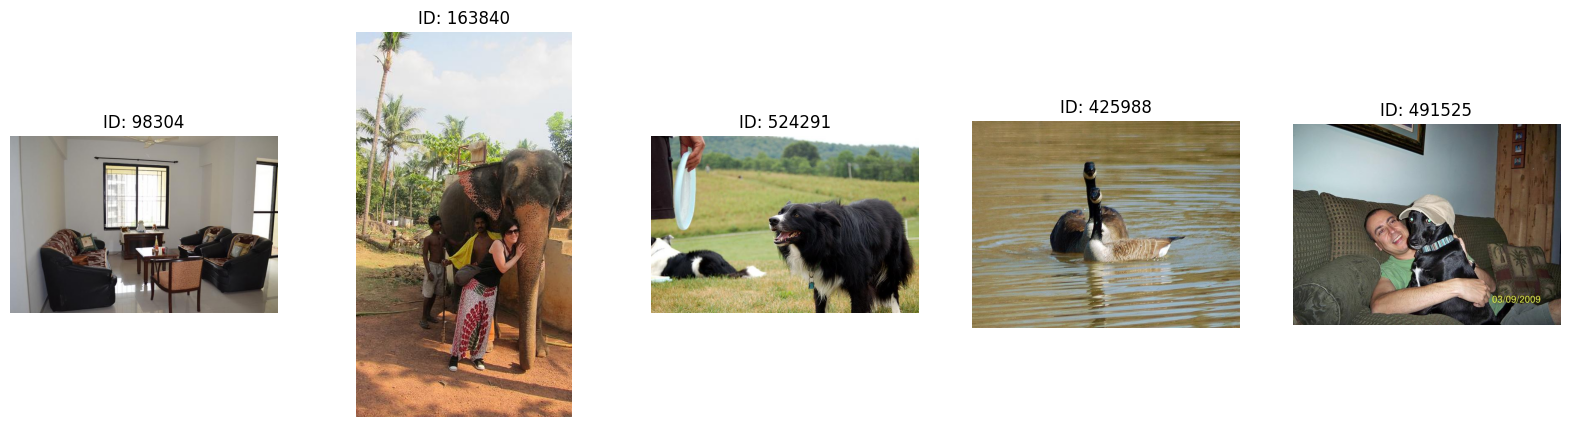

In [ ]:
# Vẽ 5 ảnh đầu tiên trong danh sách
sample_image_ids = animal_image_ids[:5]
print("5 ảnh mẫu có động vật trong ảnh")

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, image_id in enumerate(sample_image_ids):
    image_path = download_image(image_id, IMAGES_PATH)  # Tải ảnh
    if image_path:
        img = Image.open(image_path)  # Mở ảnh đã tải
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"ID: {image_id}")
plt.show()

In [ ]:
# Tải các ảnh trong list animal_image_ids
print(f"Bắt đầu tải {len(animal_image_ids)} ảnh động vật...")

for image_id in tqdm(animal_image_ids, desc="Downloading images"):
    download_image(image_id, IMAGES_PATH)  # Gọi hàm tải ảnh

print(f"\nĐã tải xong {len(animal_image_ids)} ảnh vào thư mục {IMAGES_PATH}")


Bắt đầu tải 16740 ảnh động vật...



Đã tải xong 16740 ảnh vào thư mục /content/drive/MyDrive/midterm_deep_learning/dataset/images


# Lọc câu hỏi và câu trả lời theo ảnh động vật và loại câu hỏi về số lượng và loài vật

In [ ]:
def load_vqa_data(animal_image_ids, valid_question_types={"what animal is", "how many"}):
    # Xác định đường dẫn file
    anno_file = f"{ANNOTATIONS_PATH}/v2_mscoco_train2014_annotations.json"
    ques_file = f"{QUESTIONS_PATH}/v2_OpenEnded_mscoco_train2014_questions.json"

    # Load annotations (câu trả lời)
    with open(anno_file, "r") as f:
        annotations = json.load(f)["annotations"]

    # Load questions (câu hỏi)
    with open(ques_file, "r") as f:
        questions = json.load(f)["questions"]

    # Tạo dict {question_id: question} để tra cứu nhanh
    question_dict = {q["question_id"]: q["question"] for q in questions}

    # Tạo dict {question_id: question_type} từ file annotations
    question_type_dict = {ann["question_id"]: ann["question_type"] for ann in annotations}

    # Chuyển danh sách animal_image_ids thành set để tìm kiếm nhanh hơn
    animal_image_set = set(animal_image_ids)

    # Duyệt annotations, lọc theo image_id và question_type
    qa_pairs = [
        {
            "image_id": ann["image_id"],
            "question_id": ann["question_id"],
            "question": question_dict.get(ann["question_id"], ""),
            "question_type": question_type_dict.get(ann["question_id"], ""),
            "multiple_choice_answer": ann["multiple_choice_answer"],
            "answer": [ans["answer"] for ans in ann["answers"]],  # Tạo danh sách các câu trả lời từ trường answers
            "answer_type": ann["answer_type"] if "answer_type" in ann else "unknown"
        }
        for ann in annotations
        if ann["image_id"] in animal_image_set
        and ann["question_id"] in question_dict
        and question_type_dict.get(ann["question_id"], "") in valid_question_types  # Lọc theo question_type
    ]

    # Chuyển danh sách qa_pairs thành DataFrame
    df = pd.DataFrame(qa_pairs)

    return df


In [ ]:
# Gọi hàm load_vqa_data với với các id ảnh là động vật, câu hỏi tập trung nhận dạng và số lương
df_vqa = load_vqa_data(animal_image_ids, valid_question_types={"what animal is", "how many",
                                                               "what number is", "what is this",
                                                               "what are"})
# Số lượng mẫu thu được
print(df_vqa.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13712 entries, 0 to 13711
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   image_id                13712 non-null  int64 
 1   question_id             13712 non-null  int64 
 2   question                13712 non-null  object
 3   question_type           13712 non-null  object
 4   multiple_choice_answer  13712 non-null  object
 5   answer                  13712 non-null  object
 6   answer_type             13712 non-null  object
dtypes: int64(2), object(5)
memory usage: 750.0+ KB
None


In [ ]:
def display_df_table(df, num_rows=10):
    # Định dạng cột "answer" để hiển thị danh sách câu trả lời dưới dạng chuỗi
    df = df.copy()
    df["answer"] = df["answer"].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    table = tabulate(df.head(num_rows), headers="keys", tablefmt="pretty", showindex=False)
    print(table)

# Gọi hàm để hiển thị
display_df_table(df_vqa)


+----------+-------------+---------------------------------------------+---------------+------------------------+----------------------------------------------------------------------------------------------------+-------------+
| image_id | question_id |                  question                   | question_type | multiple_choice_answer |                                               answer                                               | answer_type |
+----------+-------------+---------------------------------------------+---------------+------------------------+----------------------------------------------------------------------------------------------------+-------------+
|  137045  |  137045002  |                What is this?                | what is this  |          bear          |                     bear, bear, bear, bear, bear, bear, bear, bear, bear, bear                     |    other    |
|  131093  |  131093002  |          How many sheeps are this?          |   how many 

# Output dataset mẫu

In [ ]:
# Hiển thị 5 ảnh mẫu kèm theo câu hỏi và multiple choice answer
for index, row in df_vqa.head(5).iterrows():
    image_id = row['image_id']
    question = row['question']
    multiple_choice_answer = row['multiple_choice_answer']

    # In câu hỏi và multiple choice answer
    print(f"Câu hỏi: {question}")
    print(f"Multiple Choice Answer: {multiple_choice_answer}")
    print("-" * 65)
    # Hiển thị ảnh
    show_image(image_id)


Output hidden; open in https://colab.research.google.com to view.

# Tiền xử lý

**Tiền xử lý cho câu hỏi và câu trả lời (các từ viết tắt, dấu câu, ... )**

In [ ]:
def decontractions(phrase):
    """ Chuyển các chữ từ chữ viết tắt thành các chữ đầy đủ.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    phrase = re.sub(r"he\'s", "he is", phrase)
    phrase = re.sub(r"she\'s", "she is", phrase)
    phrase = re.sub(r"it\'s", "it is", phrase)

    phrase = re.sub(r"he\’s", "he is", phrase)
    phrase = re.sub(r"she\’s", "she is", phrase)
    phrase = re.sub(r"it\’s", "it is", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def text_preprocess(text):
    text = text.lower() # Chuyển tất cả chữ cái thành chữ thường
    text = decontractions(text) # Mở rộng các từ viết tắt (ví dụ: can't → can not)
    text = re.sub('[-,:]', ' ', text) # Thay thế dấu '-' và ',' bằng khoảng trắng
    text = re.sub("(?!<=\d)(\.)(?!\d)", '', text) # Loại bỏ dấu '.' trừ khi nằm trong số thập phân
    text = re.sub('[^A-Za-z0-9. ]+', '', text) # Xóa tất cả dấu câu, chỉ giữ lại chữ cái, số và dấu '.'
    text = re.sub(' +', ' ', text) # Xóa khoảng trắng thừa
    return text


In [ ]:
# Apply các bước tiền xử lý câu hỏi và câu trả lời
df_vqa["question"] = df_vqa["question"].apply(text_preprocess)
df_vqa["answer"] = df_vqa["answer"].apply(lambda ans_list: [text_preprocess(ans) for ans in ans_list])

# In kết quả sau khi tiền xử lý
display_df_table(df_vqa)


+----------+-------------+--------------------------------------------+---------------+------------------------+----------------------------------------------------------------------------------------------------+-------------+
| image_id | question_id |                  question                  | question_type | multiple_choice_answer |                                               answer                                               | answer_type |
+----------+-------------+--------------------------------------------+---------------+------------------------+----------------------------------------------------------------------------------------------------+-------------+
|  137045  |  137045002  |                what is this                | what is this  |          bear          |                     bear, bear, bear, bear, bear, bear, bear, bear, bear, bear                     |    other    |
|  131093  |  131093002  |          how many sheeps are this          |   how many    | 

**Tạo các label và encode các label cho câu trả lời tốt nhất để máy học một cách hiệu quả**

In [ ]:
# Lấy unique labels từ cột 'multiple_choice_answer'
labels = set(df_vqa['multiple_choice_answer'])

# Nếu có nhiều hơn 1000 nhãn, chỉ lấy 1000 nhãn đầu tiên
labels = list(labels)

# Hiển thị kết quả
print(f"Số lượng nhãn đầu ra: {len(labels)}")
print(labels)


Số lượng nhãn đầu ra: 590
['riding in sleigh', 'salad', 'chain', '9', 'fox', 'stork', 'floor', 'phones', 'pot', 'dozens', 'pasta', 'human', 'polar bear', 'monkey', 'refrigerator', 'riding elephant', 'couch', '66-05', 'ball', 'zoo', 'looking in mirror', '38', 'crossing', '75', '58', 'white', '150', 'holding reins', 'kites', 'sneakers', 'meerkat', 'yorkie', 'lights', 'no chains', '27', 'shoes', 'bulls', 'bicycle', 'oxen', 'bear', 'reins', 'toothbrush', 'grass', 'swimming', '22', 'saddle', '8691', '719', 'hats', 'street', 'reptiles', 'pulling', 'several', 'laying on bed', 'bridge', 'fridge', 'driving', 'apartments', '03/09/2009', 'cheetah', 'bunny', 'show', 'lighthouse', 'pencil', 'bike', 'oar', '153', 'roping', '35', 'rodeo', 'desert', 'feeding', 'millions', 'sweater', 'orange', 'black and white', 'dogs', 'cake', '1000', 'few dozen', 'africa', 'pigeon', 'looking', 'sink', 'holding soda', 'wreath', 'moss', 'zebra', 'bathing', '2', 'towels', 'equestrian', '13', 'watching', 'window', 'rope'

In [ ]:
# Tạo ánh xạ từ nhãn sang số nguyên duy nhất
label_mapping = {label: idx for idx, label in enumerate(labels)}

# Thêm cột 'label' vào dataframe
df_vqa['label'] = df_vqa['multiple_choice_answer'].map(label_mapping)

# Giữ lại các cột quan trọng
df_vqa = df_vqa[['image_id', 'question', 'multiple_choice_answer', 'answer', 'label']]

# Hiển thị một số dòng để kiểm tra
display_df_table(df_vqa.head(10))


+----------+--------------------------------------------+------------------------+----------------------------------------------------------------------------------------------------+-------+
| image_id |                  question                  | multiple_choice_answer |                                               answer                                               | label |
+----------+--------------------------------------------+------------------------+----------------------------------------------------------------------------------------------------+-------+
|  137045  |                what is this                |          bear          |                     bear, bear, bear, bear, bear, bear, bear, bear, bear, bear                     |  39   |
|  131093  |          how many sheeps are this          |           3            |                                    3, 3, 3, 3, 3, 0, 3, 3, 3, 3                                    |  297  |
|    25    |        how many giraffes ar

**Lưu dữ liệu vào file dataset_vqa.csv**

In [ ]:
# Lưu file csv
df_vqa.to_csv(f"{DATASET_PATH}/dataset_vqa.csv", index=False)